# 학습목표

1. Unet ++에 대한 이해

2. Unet과 Unet ++의 차이점 이해, 결과 도출

Unet

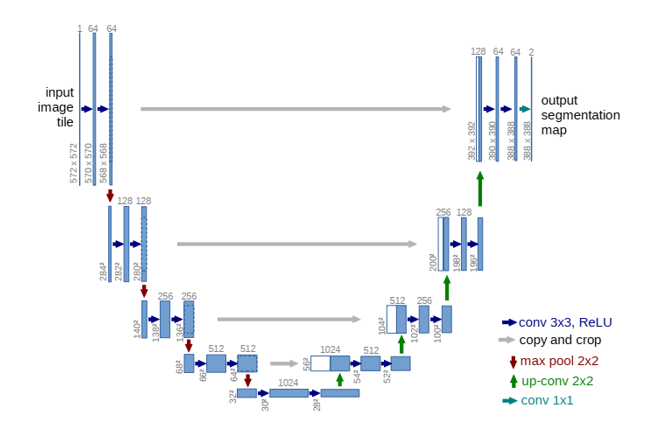



Unet ++

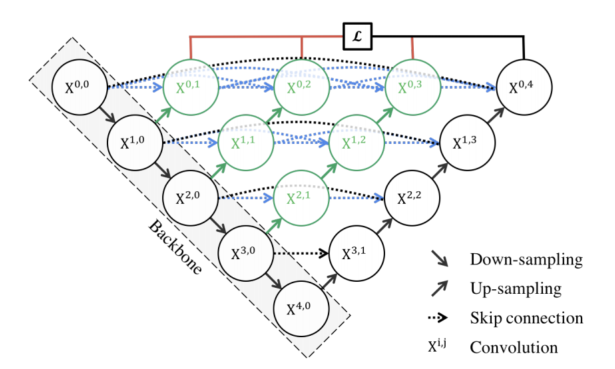

Unet++는 Unet에서 DenseNet을 추가한 거라고 생각해보면 되는가?
A. 아이디어를 가져온 것 같다.

Step 1. KITTI 데이터셋 수집과 구축
다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

Step 2. U-Net++ 모델의 구현
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

Unet 구현

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

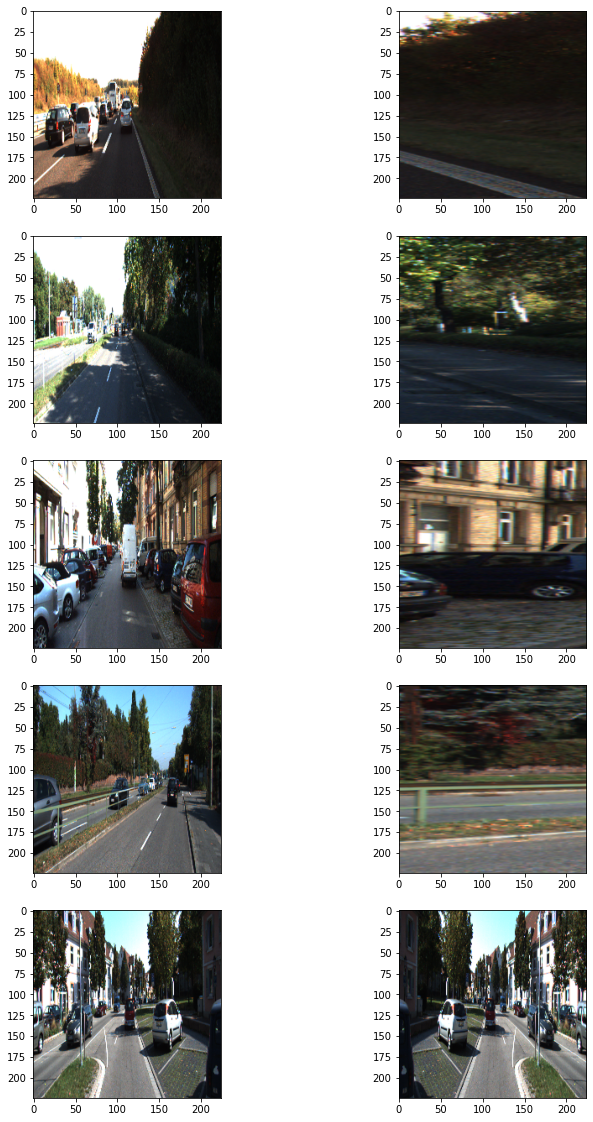

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
import os
import math
import numpy as np
from glob import glob
from imageio import imread
import tensorflow as tf

class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequence를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=8,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize 및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[index * self.batch_size : (index + 1) * self.batch_size]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8) * 1
            data_dict = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data_dict)
            inputs[i] = augmented["image"] / 255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습 중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train:
            np.random.shuffle(self.indexes)
        return self.indexes


In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    batch_size=8,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Cropping2D, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def int_shape(tensor):
    return K.int_shape(tensor)

def get_crop_layer(target, refer):
    target_shape = int_shape(target)
    refer_shape = int_shape(refer)
    # width, the 3rd dimension
    cw = target_shape[2] - refer_shape[2]
    assert cw >= 0
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target_shape[1] - refer_shape[1]
    assert ch >= 0
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)
    
    crop = Cropping2D(cropping=((ch1, ch2), (cw1, cw2)))(target)
    return crop

def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path
    conv1 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv5)
    
    # Expanding path
    up1 = Conv2DTranspose(512, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv5)
    crop1 = get_crop_layer(conv4, up1)
    concat1 = concatenate([crop1, up1], axis=3)
    conv6 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(concat1)
    conv6 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv6)
    
    up2 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv6)
    crop2 = get_crop_layer(conv3, up2)
    concat2 = concatenate([crop2, up2], axis=3)
    conv7 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(concat2)
    conv7 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv7)
    
    up3 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv7)
    crop3 = get_crop_layer(conv2, up3)
    concat3 = concatenate([crop3, up3], axis=3)
    conv8 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(concat3)
    conv8 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv8)
    
    up4 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv8)
    crop4 = get_crop_layer(conv1, up4)
    concat4 = concatenate([crop4, up4], axis=3)
    conv9 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(concat4)
    conv9 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid', kernel_initializer='he_normal')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_model(input_shape=(224, 224, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Unet ++

In [7]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

# -----------------------------
# Helper: Convolutional Block
# -----------------------------
def conv_block(x, filters, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(x)
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(x)
    return x

# -----------------------------
# Unet++ Model (Nested U-Net)
# -----------------------------
def unetplusplus(input_shape=(224, 224, 3), num_classes=1, deep_supervision=False):
    """
    Unet++ 모델 구현.
    - input_shape: 입력 이미지 크기.
    - num_classes: 출력 채널 수 (보통 이진 분할이면 1).
    - deep_supervision: True이면, 각 decoder 단계의 출력을 최종 출력으로 사용 (다중 출력).
      기본값은 False로 단일 출력 X[0, num_levels-1]를 사용합니다.
    """
    inputs = Input(input_shape)
    # 각 단계의 필터 수 (encoder 깊이에 따라 증가)
    filters = [64, 128, 256, 512, 1024]
    num_levels = len(filters)
    X = {}  # (i, j) 형태의 노드 저장. i: depth index, j: nested level
    
    # -----------------------------
    # Encoder (X[i,0] nodes)
    # -----------------------------
    X[(0, 0)] = conv_block(inputs, filters[0])
    X[(1, 0)] = conv_block(MaxPooling2D(pool_size=(2, 2))(X[(0, 0)]), filters[1])
    X[(2, 0)] = conv_block(MaxPooling2D(pool_size=(2, 2))(X[(1, 0)]), filters[2])
    X[(3, 0)] = conv_block(MaxPooling2D(pool_size=(2, 2))(X[(2, 0)]), filters[3])
    X[(4, 0)] = conv_block(MaxPooling2D(pool_size=(2, 2))(X[(3, 0)]), filters[4])
    
    # -----------------------------
    # Decoder: Nested Skip Connections
    # -----------------------------
    # j: nested level, i: depth index (0 <= i < num_levels - j)
    for j in range(1, num_levels):
        for i in range(num_levels - j):
            if j == 1:
                # 첫 번째 nested level: 단순하게 encoder 노드와 upsampled 하위 노드를 concat
                up = Conv2DTranspose(filters[i], 2, strides=(2, 2), padding='same', activation='relu')(X[(i+1, 0)])
                X[(i, j)] = conv_block(concatenate([X[(i, 0)], up], axis=3), filters[i])
            else:
                # j>=2: 이전 단계의 같은 depth의 여러 nested 노드와 upsampled 하위 노드를 concat
                up = Conv2DTranspose(filters[i], 2, strides=(2, 2), padding='same', activation='relu')(X[(i+1, j-1)])
                concat_list = [X[(i, k)] for k in range(j)]  # X[(i,0)], X[(i,1)], ..., X[(i, j-1)]
                concat_list.append(up)
                X[(i, j)] = conv_block(concatenate(concat_list, axis=3), filters[i])
    
    # -----------------------------
    # Output Layer(s)
    # -----------------------------
    if deep_supervision:
        # 다중 출력: 각 nested 레벨 X[(0,j)] (j=1,2,...,num_levels-1)마다 출력층을 둠.
        outputs = [Conv2D(num_classes, 1, activation='sigmoid')(X[(0, j)]) for j in range(1, num_levels)]
    else:
        # 단일 출력: 가장 nested된 X[(0, num_levels-1)] 사용.
        outputs = Conv2D(num_classes, 1, activation='sigmoid')(X[(0, num_levels-1)])
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# -----------------------------
# Dice Coefficient & Loss Functions
# -----------------------------
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# -----------------------------
# 모델 생성, 컴파일, 학습 및 저장 예시
# -----------------------------
# 예시에서는 deep_supervision=False로 단일 출력을 사용합니다.
model = unetplusplus(input_shape=(224, 224, 3), num_classes=1, deep_supervision=False)

#model.compile(optimizer=Adam(1e-4), loss=bce_dice_loss, metrics=[dice_coef])

# 학습 데이터와 검증 데이터는 데이터 제너레이터 train_generator, test_generator를 사용한다고 가정합니다.
# model.fit(
#     train_generator,
#     validation_data=test_generator,
#     steps_per_epoch=len(train_generator),
#     epochs=100,
# )


# 모델 요약 출력
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

Unet
Total params: 31,031,745
Trainable params: 31,031,745

Unet ++
Total params: 36,157,953
Trainable params: 36,157,953

import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K


# Unet++ 모델 생성 (이전 답변에서 정의한 unet_plus_plus 함수 사용)
model = unet_plus_plus(input_shape=(224, 224, 3), num_classes=1)

# 모델 컴파일: Adam 옵티마이저와 결합 손실 함수를 사용하며, 평가 지표로 dice_coef를 사용
model.compile(optimizer=Adam(1e-4), loss=bce_dice_loss, metrics=[dice_coef])

# 학습 수행 (train_generator와 test_generator는 데이터 제너레이터)
model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

# 모델 저장 경로 설정 (Unet++ 모델임을 명시하기 위해 파일명을 변경)
model_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/seg_model_unetpp.h5'
model.save(model_path)


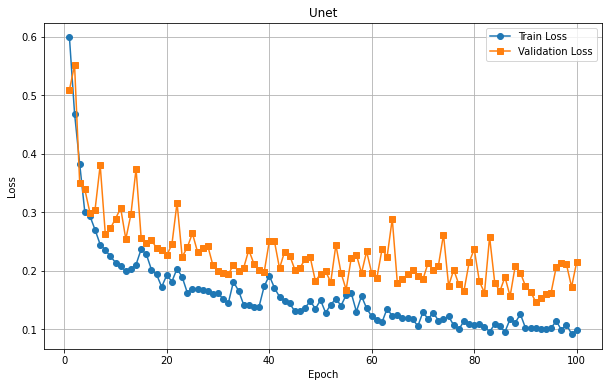

In [8]:
import matplotlib.pyplot as plt

# Epoch 번호 (1부터 100까지)
epochs = list(range(1, 101))

train_loss = [
    0.5989, 0.4688, 0.3827, 0.3002, 0.2934, 0.2699, 0.2446, 0.2351, 0.2244, 0.2138,
    0.2081, 0.1990, 0.2029, 0.2103, 0.2367, 0.2280, 0.2018, 0.1935, 0.1722, 0.1923,
    0.1813, 0.2034, 0.1890, 0.1624, 0.1687, 0.1683, 0.1670, 0.1657, 0.1600, 0.1625,
    0.1506, 0.1440, 0.1809, 0.1657, 0.1418, 0.1408, 0.1376, 0.1382, 0.1729, 0.1915,
    0.1707, 0.1552, 0.1479, 0.1438, 0.1301, 0.1303, 0.1363, 0.1481, 0.1346, 0.1496,
    0.1279, 0.1417, 0.1520, 0.1399, 0.1581, 0.1614, 0.1300, 0.1564, 0.1355, 0.1215,
    0.1163, 0.1115, 0.1351, 0.1222, 0.1249, 0.1193, 0.1187, 0.1165, 0.1052, 0.1292,
    0.1169, 0.1283, 0.1145, 0.1166, 0.1216, 0.1065, 0.0993, 0.1139, 0.1081, 0.1071,
    0.1091, 0.1040, 0.0956, 0.1081, 0.1048, 0.0954, 0.1171, 0.1107, 0.1255, 0.1020,
    0.1015, 0.1016, 0.1007, 0.0993, 0.1017, 0.1139, 0.0987, 0.1076, 0.0916, 0.0982
]


val_loss = [
    0.5092, 0.5517, 0.3501, 0.3391, 0.2990, 0.3041, 0.3805, 0.2628, 0.2725, 0.2890,
    0.3069, 0.2539, 0.2963, 0.3742, 0.2555, 0.2472, 0.2529, 0.2381, 0.2349, 0.2262,
    0.2450, 0.3163, 0.2234, 0.2398, 0.2638, 0.2320, 0.2380, 0.2422, 0.2092, 0.1993,
    0.1960, 0.1934, 0.2097, 0.1986, 0.2046, 0.2354, 0.2118, 0.2007, 0.1972, 0.2500,
    0.2507, 0.2039, 0.2327, 0.2257, 0.2014, 0.2050, 0.2194, 0.2225, 0.1822, 0.1943,
    0.1986, 0.1804, 0.2439, 0.1963, 0.1675, 0.2217, 0.2275, 0.1956, 0.2328, 0.1954,
    0.1875, 0.2365, 0.2238, 0.2886, 0.1783, 0.1849, 0.1939, 0.2017, 0.1901, 0.1853,
    0.2133, 0.2015, 0.2081, 0.2617, 0.1741, 0.2013, 0.1764, 0.1654, 0.2139, 0.2370,
    0.1817, 0.1620, 0.2576, 0.1795, 0.1647, 0.1890, 0.1561, 0.2078, 0.1966, 0.1735,
    0.1638, 0.1465, 0.1526, 0.1596, 0.1623, 0.2061, 0.2134, 0.2106, 0.1720, 0.2151
]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Unet')
plt.legend()
plt.grid(True)
plt.show()


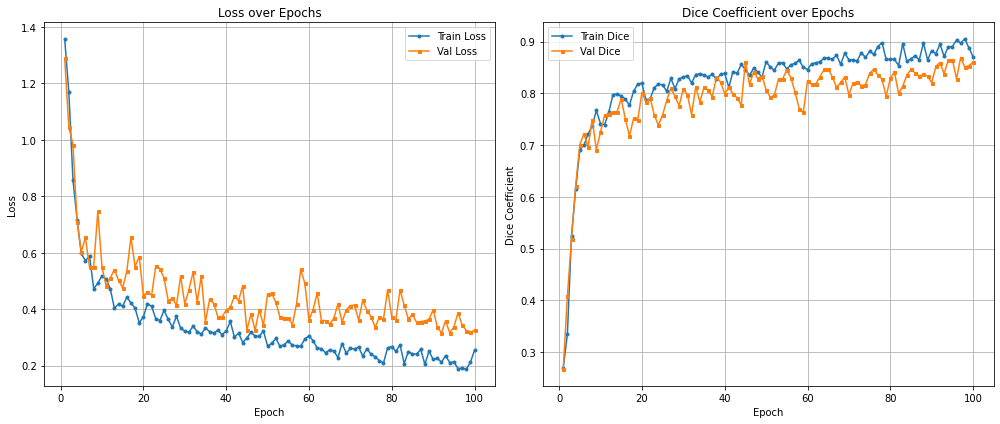

In [9]:
import matplotlib.pyplot as plt

# 1 ~ 100 에포크
epochs = list(range(1, 101))

# 각 에포크별 Training Loss 값
train_loss = [
    1.3576, 1.1694, 0.8577, 0.7175, 0.5978, 0.5714, 0.5890, 0.4727, 0.4917, 0.5188,
    0.5068, 0.4730, 0.4042, 0.4180, 0.4109, 0.4425, 0.4226, 0.4036, 0.3522, 0.3727,
    0.4201, 0.4098, 0.3666, 0.3600, 0.3964, 0.3638, 0.3368, 0.3755, 0.3328, 0.3225,
    0.3179, 0.3399, 0.3209, 0.3117, 0.3334, 0.3209, 0.3157, 0.3250, 0.3100, 0.3224,
    0.3567, 0.3008, 0.3154, 0.2819, 0.2983, 0.3186, 0.3041, 0.3034, 0.3232, 0.2701,
    0.2786, 0.2965, 0.2684, 0.2743, 0.2879, 0.2719, 0.2708, 0.2688, 0.2945, 0.3059,
    0.2886, 0.2619, 0.2607, 0.2456, 0.2562, 0.2520, 0.2288, 0.2783, 0.2448, 0.2609,
    0.2593, 0.2655, 0.2339, 0.2605, 0.2396, 0.2322, 0.2182, 0.2094, 0.2634, 0.2677,
    0.2506, 0.2740, 0.2072, 0.2501, 0.2419, 0.2409, 0.2576, 0.2047, 0.2515, 0.2220,
    0.2261, 0.2125, 0.2354, 0.2112, 0.2136, 0.1896, 0.1912, 0.1872, 0.2125, 0.2546
]

# 각 에포크별 Training Dice Coefficient 값
train_dice = [
    0.2686, 0.3341, 0.5248, 0.6143, 0.6911, 0.6997, 0.7215, 0.7371, 0.7670, 0.7415,
    0.7395, 0.7630, 0.7975, 0.7988, 0.7952, 0.7887, 0.7770, 0.8041, 0.8180, 0.8195,
    0.7866, 0.7895, 0.8111, 0.8179, 0.8163, 0.8041, 0.8289, 0.8091, 0.8279, 0.8316,
    0.8340, 0.8199, 0.8364, 0.8381, 0.8352, 0.8317, 0.8373, 0.8268, 0.8370, 0.8386,
    0.8116, 0.8422, 0.8387, 0.8560, 0.8459, 0.8349, 0.8487, 0.8411, 0.8314, 0.8608,
    0.8511, 0.8445, 0.8590, 0.8589, 0.8471, 0.8555, 0.8577, 0.8640, 0.8500, 0.8460,
    0.8572, 0.8590, 0.8610, 0.8682, 0.8685, 0.8657, 0.8742, 0.8561, 0.8775, 0.8648,
    0.8643, 0.8630, 0.8783, 0.8694, 0.8811, 0.8756, 0.8905, 0.8980, 0.8655, 0.8659,
    0.8658, 0.8537, 0.8961, 0.8616, 0.8670, 0.8727, 0.8647, 0.8973, 0.8648, 0.8825,
    0.8767, 0.8948, 0.8717, 0.8897, 0.8905, 0.9029, 0.8973, 0.9052, 0.8878, 0.8704
]

# 각 에포크별 Validation Loss 값
val_loss = [
    1.2886, 1.0456, 0.9835, 0.7086, 0.6033, 0.6542, 0.5491, 0.5505, 0.7465, 0.5502,
    0.4829, 0.5100, 0.5407, 0.5025, 0.4760, 0.5339, 0.6558, 0.5509, 0.5866, 0.4483,
    0.4607, 0.4492, 0.5547, 0.5436, 0.5102, 0.4298, 0.4386, 0.4143, 0.5175, 0.4185,
    0.4685, 0.5309, 0.4255, 0.5166, 0.3541, 0.4353, 0.4201, 0.3726, 0.3727, 0.3963,
    0.4072, 0.4458, 0.4302, 0.4839, 0.3265, 0.3822, 0.3261, 0.3984, 0.3427, 0.4528,
    0.4568, 0.4245, 0.3723, 0.3680, 0.3701, 0.3454, 0.4191, 0.5414, 0.4917, 0.3607,
    0.3984, 0.4586, 0.3600, 0.3600, 0.3466, 0.3674, 0.4196, 0.3544, 0.3980, 0.4129,
    0.4145, 0.3611, 0.4324, 0.3950, 0.3738, 0.3358, 0.3717, 0.3653, 0.4688, 0.3730,
    0.3629, 0.4689, 0.4138, 0.3656, 0.3813, 0.3533, 0.3562, 0.3586, 0.3641, 0.3984,
    0.3367, 0.3165, 0.3588, 0.3166, 0.3370, 0.3875, 0.3442, 0.3245, 0.3177, 0.3264
]

# 각 에포크별 Validation Dice Coefficient 값
val_dice = [
    0.2666, 0.4078, 0.5191, 0.6218, 0.7006, 0.7223, 0.6961, 0.7494, 0.6912, 0.7247,
    0.7582, 0.7605, 0.7646, 0.7642, 0.7894, 0.7508, 0.7174, 0.7518, 0.7484, 0.8015,
    0.7834, 0.7904, 0.7577, 0.7385, 0.7584, 0.7864, 0.8103, 0.7939, 0.7762, 0.8086,
    0.7972, 0.7590, 0.8125, 0.7833, 0.8113, 0.8063, 0.7935, 0.8311, 0.8219, 0.7995,
    0.8114, 0.7991, 0.7911, 0.7774, 0.8606, 0.8171, 0.8416, 0.8285, 0.8344, 0.8068,
    0.7925, 0.7963, 0.8281, 0.8280, 0.8453, 0.8298, 0.8024, 0.7705, 0.7637, 0.8248,
    0.8174, 0.8179, 0.8320, 0.8462, 0.8469, 0.8319, 0.8116, 0.8210, 0.8316, 0.7972,
    0.8197, 0.8220, 0.8149, 0.8169, 0.8384, 0.8467, 0.8356, 0.8273, 0.7942, 0.8289,
    0.8412, 0.7998, 0.8135, 0.8355, 0.8462, 0.8393, 0.8337, 0.8365, 0.8334, 0.8205,
    0.8523, 0.8595, 0.8375, 0.8645, 0.8652, 0.8280, 0.8691, 0.8506, 0.8538, 0.8599
]

# 그래프 그리기: 좌측에는 Loss, 우측에는 Dice Coefficient를 표시합니다.
plt.figure(figsize=(14, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o', markersize=3)
plt.plot(epochs, val_loss, label='Val Loss', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Dice Coefficient 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_dice, label='Train Dice', marker='o', markersize=3)
plt.plot(epochs, val_dice, label='Val Dice', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficient over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:

# Deep Supervision 적용 Unet++ 모델 생성
model1 = unetplusplus(input_shape=(224, 224, 3), num_classes=1, deep_supervision=True)
num_outputs = len(model1.outputs)
print("Number of outputs:", num_outputs)

# 다중 출력에 대해 동일한 손실 함수를 적용하고, 각 출력에 동일한 가중치를 부여합니다.
model1.compile(optimizer=Adam(1e-4),
              loss=[bce_dice_loss] * num_outputs,
              loss_weights=[1.0] * num_outputs,
              metrics=[dice_coef])

# 학습 수행 (train_generator와 test_generator는 데이터 제너레이터)
model1.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=0,
)

# 모델 저장 경로 설정 (파일명에 'unetpp'를 사용하여 저장) 이미 저장해서 따로 저장 X
# model_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/seg_model_unetppT.h5'
# model1.save(model_path)


Number of outputs: 4


중간에 gpu오류 발생하여 -> batch size 16 -> 8로 조정

In [11]:
model_path1 = os.getenv('HOME') + '/aiffel/semantic_segmentation/seg_model_unet.h5'
model_path2 = os.getenv('HOME') + '/aiffel/semantic_segmentation/seg_model_unetppT.h5'

# model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path1)
model1 = tf.keras.models.load_model(model_path2, 
            custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_coef': dice_coef})

In [22]:
def get_output(model, preproc, image_path, output_path=None, label_path=None):
    """
    model : tf.keras 모델 (U-Net 또는 U-Net++)
    preproc : 전처리 함수 (이미지 -> 모델 입력 형태로 변환)
    image_path : 원본 이미지 경로
    output_path : (옵션) 블렌딩된 결과 이미지를 저장할 경로
    label_path : 타겟 레이블 경로 (있을 경우)
    
    반환값 : (blended_img, raw_mask, target_img)
      - blended_img : 시각화용 RGBA 이미지 (원본 + 예측 마스크)
      - raw_mask    : (H, W) 형태의 이진 마스크 (0 또는 255)
      - target_img  : 레이블 이미지 (레이블이 있을 경우), 없으면 None
    """
    # 원본 이미지 읽기
    origin_img = imread(image_path)
    
    # 원본 이미지가 4채널(RGBA)인 경우, 3채널(RGB)로 변환
    if origin_img.ndim == 3 and origin_img.shape[-1] == 4:
        origin_img = origin_img[..., :3]
    
    data = {"image": origin_img}
    processed = preproc(**data)
    
    # 전처리된 이미지가 4채널이거나 채널 수가 3이 아닌 경우 3채널만 사용
    image_input = processed["image"]
    if image_input.ndim == 3:
        if image_input.shape[-1] != 3:
            image_input = image_input[..., :3]
    else:
        raise ValueError("전처리된 이미지의 차원이 올바르지 않습니다.")
    
    # 모델 예측 (입력은 (1, 224, 224, 3))
    pred = model(np.expand_dims(image_input / 255, axis=0))
    
    # U-Net++의 경우 예측 결과가 리스트일 수 있으므로 마지막 출력을 사용
    if isinstance(pred, list):
        mask_arr = pred[-1].numpy()
    else:
        mask_arr = pred.numpy()
    
    # 임계값 적용 (0 또는 255)
    raw_mask = (mask_arr > 0.5).astype(np.uint8) * 255
    
    # 불필요한 차원 제거: (1, 224, 224, 1) → (224, 224)
    raw_mask = np.squeeze(raw_mask, axis=0)
    if raw_mask.ndim == 3 and raw_mask.shape[-1] == 1:
        raw_mask = np.squeeze(raw_mask, axis=-1)
    
    # 시각화를 위한 블렌딩 처리
    from PIL import Image
    mask_img = Image.fromarray(raw_mask)
    background = Image.fromarray(origin_img).convert('RGBA')
    
    # 원본 크기에 맞춰 리사이즈 후 RGBA 변환
    mask_img = mask_img.resize(
        (origin_img.shape[1], origin_img.shape[0]),
        resample=Image.NEAREST
    ).convert('RGBA')
    
    blended_img = Image.blend(background, mask_img, alpha=0.5)
    
    # 결과 이미지 저장 (옵션)
    if output_path:
        blended_img.save(output_path)
    
    # 레이블 이미지 로드 (존재하면)
    import os
    if label_path is not None and os.path.exists(label_path):
        target_img = imread(label_path)
    else:
        target_img = None
    
    return blended_img, raw_mask, target_img


In [13]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/semantic_segmentation/data/training./result_001.png'

In [14]:
import numpy as np

def calculate_iou_score(target, prediction):
    # Intersection: 두 마스크에서 모두 1인 영역의 개수
    intersection = np.logical_and(target, prediction).sum()
    
    # Union: 두 마스크 중 하나라도 1인 영역의 개수
    union = np.logical_or(target, prediction).sum()
    
    # IoU 계산: union이 0이 아닐 때만 계산, 0이면 IoU는 0으로 처리
    iou_score = float(intersection) / float(union) if union != 0 else 0.0
    
    print('IoU : %f' % iou_score)
    return iou_score

In [15]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

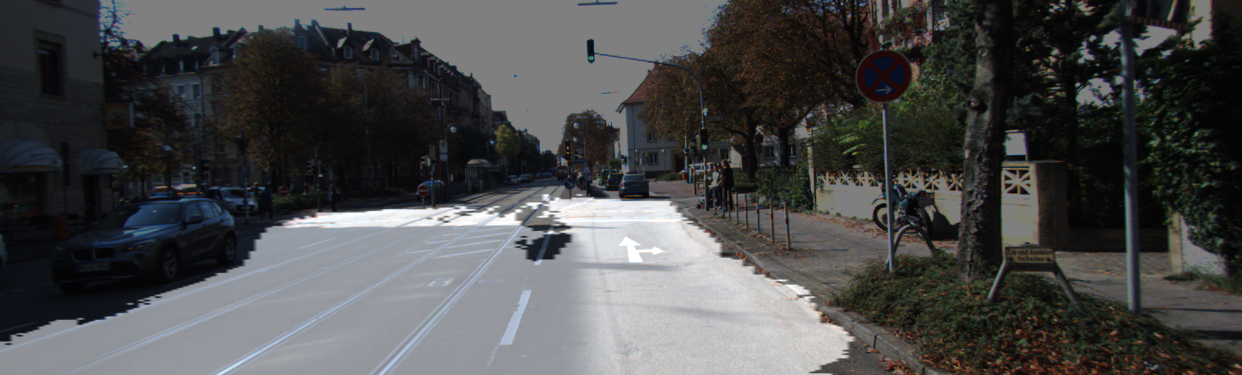

IoU : 0.867857


0.8678565836856114

In [16]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

Unet ++ model 출력이 (1,1,224), lu1 오류가 발생

In [17]:
print("Processed image shape:", processed["image"].shape)

Processed image shape: (224, 224, 3)


In [18]:
pred = model1(np.expand_dims(processed["image"] / 255, axis=0))

# 예측 결과가 리스트인 경우, 각 요소의 shape를 출력합니다.
if isinstance(pred, list):
    for idx, output in enumerate(pred):
        print(f"Output {idx} shape: {output.shape}")
else:
    print("Raw prediction shape:", pred.shape)

Output 0 shape: (1, 224, 224, 1)
Output 1 shape: (1, 224, 224, 1)
Output 2 shape: (1, 224, 224, 1)
Output 3 shape: (1, 224, 224, 1)


출력이 여러개 나오는데 따로 처리를 안해서 생긴 문제로 보입니다. 마지막층에 꺼를 선택하여 사용하였습니다!

def evaluate_model(model, test_preproc, dir_path, start=1, end=100):
    iou_scores = []
    for i in range(start, end+1):
        # 파일 경로 구성 (예시)
        image_path = os.path.join(dir_path, 'image_2', f'00{str(i).zfill(4)}_10.png')
        label_path = os.path.join(dir_path, 'semantic', f'00{str(i).zfill(4)}_10.png')
        
        # get_output 함수 호출: 반환값은 (blended_img, raw_mask, target)
        # blended_img는 시각화용으로 사용되나 여기서는 출력하지 않습니다.
        _, raw_mask, target = get_output(model, test_preproc,
                                         image_path=image_path,
                                         output_path=None,
                                         label_path=label_path)
        if target is None:
            continue

        # 타겟 이미지가 컬러라면 하나의 채널만 선택 (예: 첫 번째 채널)
        if target.ndim == 3:
            target_mask = target[:, :, 0]
        else:
            target_mask = target

        # 평가를 위해 raw_mask (예측 마스크)의 크기를 타겟 크기로 맞춥니다.
        if target_mask.shape != raw_mask.shape:
            prediction_resized = np.array(
                Image.fromarray(raw_mask).resize(
                    (target_mask.shape[1], target_mask.shape[0]),
                    resample=Image.NEAREST
                )
            )
        else:
            prediction_resized = raw_mask

        # IoU 계산 (calculate_iou_score 함수가 float 값을 반환한다고 가정)
        iou = calculate_iou_score(target_mask, prediction_resized)
        iou_scores.append(iou)
    return np.mean(iou_scores)

# U-Net 모델 평가
avg_iou_unet = evaluate_model(model, test_preproc, dir_path, start=1, end=100)
print("Average IoU for U-Net:", avg_iou_unet)

# U-Net++ 모델 평가 (model1로 가정)
avg_iou_unetpp = evaluate_model(model1, test_preproc, dir_path, start=1, end=100)
print("Average IoU for U-Net++:", avg_iou_unetpp)

Average IoU for U-Net: 0.18583096559765536

Average IoU for U-Net++: 0.22963853671325926

IOU 값이 너무 낮게 나오는데 음 처리과정에서 너무 많이 수정해서 그런 것 같습니다. 시각화 에서는 크게 문제는 없어보입니다.

정량적으로 계산했을 때 U-net ++가 더 잘하는 것 같다.

확인해보고 싶은 것은 그림자가 있을 때나 도로 상태가 깨끗하지 않을 때 확인해보고 싶다.

Processing snow.PNG with model (U-Net)...


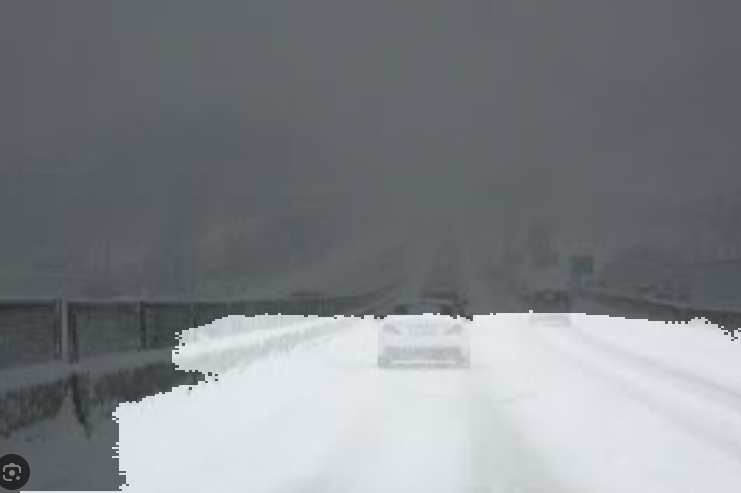

Processing snow.PNG with model1 (U-Net++)...


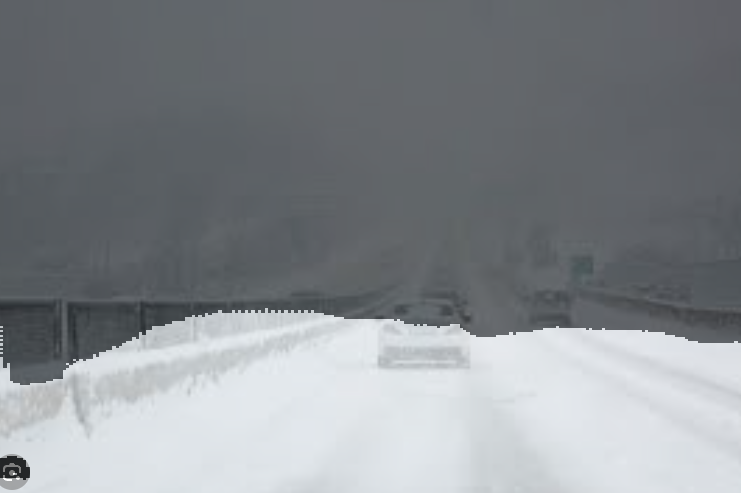

Processing snow1.PNG with model (U-Net)...


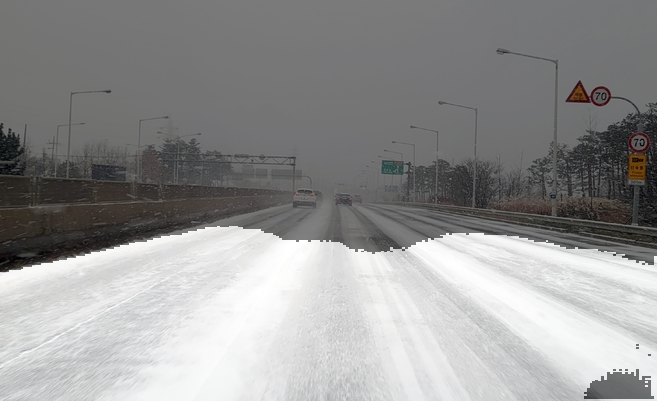

Processing snow1.PNG with model1 (U-Net++)...


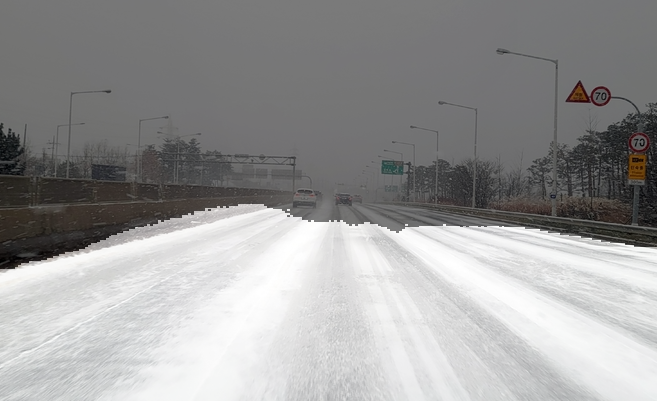

Processing snow2.PNG with model (U-Net)...


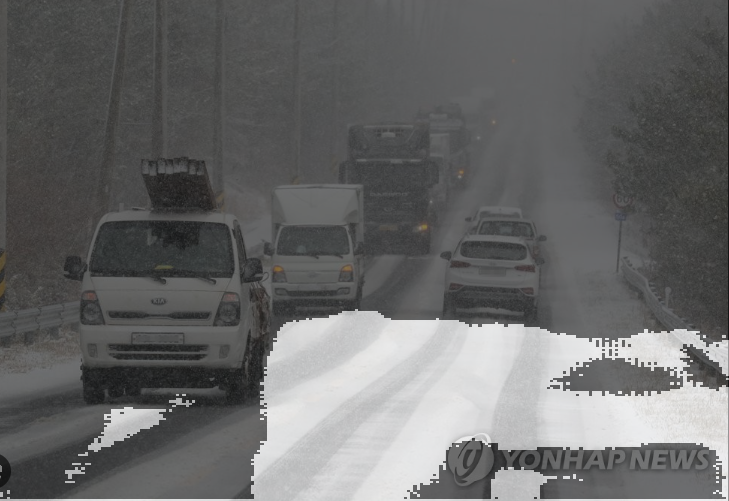

Processing snow2.PNG with model1 (U-Net++)...


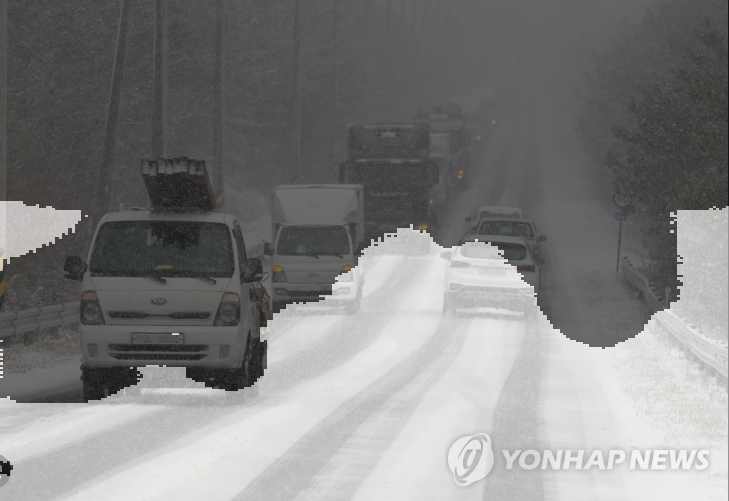

Processing shadow1.PNG with model (U-Net)...


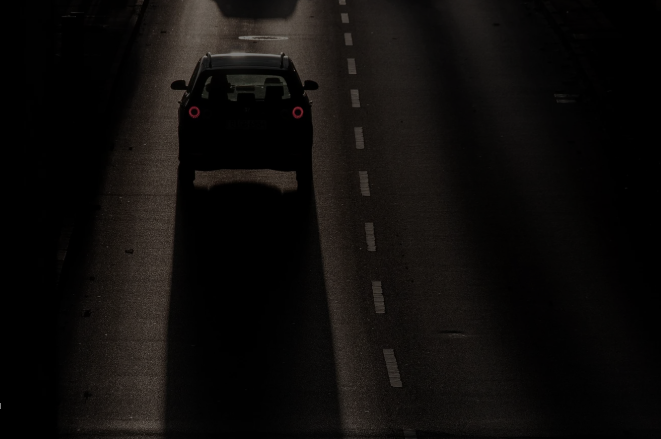

Processing shadow1.PNG with model1 (U-Net++)...


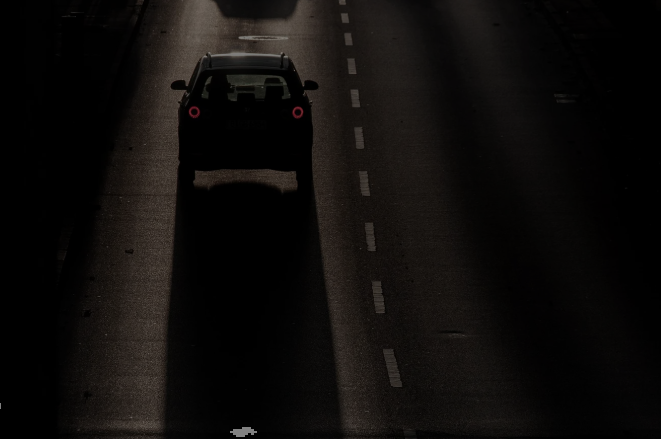

In [23]:
import os

# 처리할 이미지 파일 목록
image_files = ["snow.PNG", "snow1.PNG", "snow2.PNG", "shadow1.PNG"]

# 이미지들이 위치한 폴더 경로
base_dir = "/aiffel/aiffel/semantic_segmentation"

# 각 이미지에 대해 모델(model)과 model1에 대한 시각화 결과 확인
for fname in image_files:
    image_path = os.path.join(base_dir, fname)
    print(f"Processing {fname} with model (U-Net)...")
    
    # U-Net 모델로 get_output 호출 (레이블 필요 없으므로 label_path=None)
    blended_img, pred_mask, _ = get_output(
        model,
        test_preproc,
        image_path=image_path,
        output_path=None,
        label_path=None
    )
    # 시각화 (PIL.Image 객체이므로 .show() 호출)
    blended_img.show(title=f"{fname} - U-Net")
    
    print(f"Processing {fname} with model1 (U-Net++)...")
    blended_img, pred_mask, _ = get_output(
        model1,
        test_preproc,
        image_path=image_path,
        output_path=None,
        label_path=None
    )
    blended_img.show(title=f"{fname} - U-Net++")


Unet ++ 가 조금 더 잘잡는 것 같다. 하지만 아직 최적화를 하지않고 내가 전처리를 좀 잘못한 것 같아서 아쉽다.

https://wsshin.tistory.com/2 Unet ++ 할 때 참고한 내용입니다.

# 회고록



이론적으로 계속 헷갈리는 부분이 많아서 찾아보느냐고 프로젝트 시간이 좀 줄어드는게 아쉽습니다. 벌써 반이 지나가는데 이 시간들을 귀하게 생각하고 좀 더 효율적으로 시간을 써야겠습니다.